# Content

In [3]:
from data_process import *
from utility import *
from model import *
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

In [4]:
# data process: there we only augment the train and validating data, instead of test data
train_x, train_y, test_x, test_y = get_data('./recognition.csv')

In [5]:
mu, std = calculate_mean_std(train_x)

In [6]:
# hyper parameters:
batch_size = 64
num_workers = 4

# important part: data augmentation
train_augment = transforms.Compose([
    transforms.RandomResizedCrop(48, scale=(0.8, 1.2)),
    transforms.RandomApply([
        transforms.RandomAffine(0, translate=(0.2, 0.2)),
        transforms.RandomPerspective(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=.5, contrast=.5, saturation=.5, hue=.3),
    ], p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.TenCrop(40),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    transforms.Lambda(lambda crops: torch.stack([transforms.Normalize(mu, std)(crop) for crop in crops])),
    transforms.Lambda(lambda crops: torch.stack([transforms.RandomErasing(p=.4)(crop) for crop in crops])),
])
basic_trans = transforms.Compose([
    transforms.CenterCrop(40),
    transforms.ToTensor(),
])
test_trans = transforms.Compose([
    transforms.TenCrop(40),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    transforms.Lambda(lambda crops: torch.stack([transforms.Normalize(mu, std)(crop) for crop in crops])),
])
train_set = custom_dataset(train_x, train_y, input_transform=train_augment)
test_train_set = custom_dataset(train_x, train_y, input_transform=test_trans)
test_set = custom_dataset(test_x, test_y, input_transform=test_trans)
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size, num_workers=num_workers)
test_train_loader = DataLoader(test_train_set, shuffle=False, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size, num_workers=num_workers)

In [ ]:
alter_net = alter_cls([2, 2, 2, 2])

In [7]:
alter_net = torch.load('./b_net.pkl')

In [10]:
total_acc_list, total_loss_list = [], []

In [9]:
torch.backends.cudnn.benchmark = True
alter_net = alter_net.to(device)

In [8]:
mom = .9
max_epoch = 20
wd = 1e-6
lr = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # default cuda

In [11]:
# alpha = torch.FloatTensor([.6, 1., .8, .4, .8, .4, .6]).to(device)
alpha = torch.FloatTensor([1., 1., 2, .8, 1.6, 1.2, 1.2]).to(device)
criterion = adaptive_loss(alpha, 2, .05, num_class)
# criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=alter_net.parameters(), lr=lr, weight_decay=wd, momentum=mom, nesterov=True)

In [ ]:
# train
train_acc_list, train_loss_list = train(alter_net, criterion, optimizer, train_loader, device, max_epoch, is_tenCrop=True)

train accuracy: 0.989899


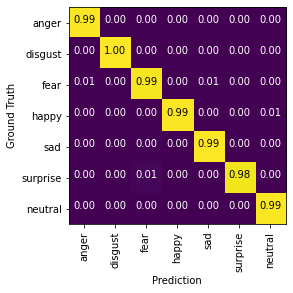

In [19]:
# test on train set
train_pre = test2pre(c_net, test_train_loader, device, is_tenCrop=True)
train_acc = cal_acc(train_pre, train_y)
print('train accuracy: {:.6f}'.format(train_acc))
draw_confusion_matrix(train_pre, train_y, in_probability=True)

test accuracy: 0.733352


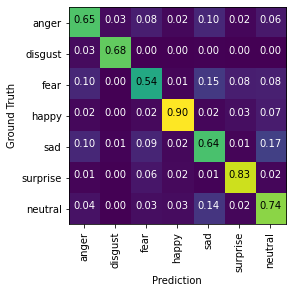

********************
evaluating indicators are as below:
BER: 0.165755
MCC: 0.687042
sensitivity: 0.714186
specificity: 0.954305
recall: 0.714186
precision: 0.754811
F1: 0.730063
auROC: 0.834245
auPRC: 0.585752
kappa: 0.677063
hamming: 0.266648
********************


In [20]:
test_pre = test2pre(c_net, test_loader, device, is_tenCrop=True)
test_acc = cal_acc(test_pre, test_y)
print('test accuracy: {:.6f}'.format(test_acc))
draw_confusion_matrix(test_pre, test_y, in_probability=True)
test_eval = cal_all_eval(test_pre, test_y)
print_eval(test_eval)

In [51]:
a_net = torch.load('./a_net.pkl').to(device)
b_net = torch.load('./b_net.pkl').to(device)
c_net = torch.load('./c_net.pkl').to(device)

test accuracy: 0.740457


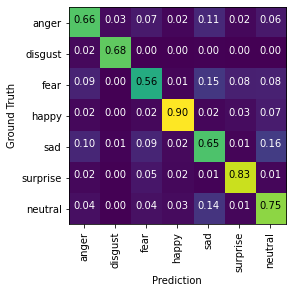

********************
evaluating indicators are as below:
BER: 0.162029
MCC: 0.694795
sensitivity: 0.720437
specificity: 0.955505
recall: 0.720437
precision: 0.761644
F1: 0.736618
auROC: 0.837971
auPRC: 0.593511
kappa: 0.685628
hamming: 0.259543
********************


In [56]:
test_pre = joint_test([a_net, b_net, c_net], [.1, .3, .6], test_loader, device, is_tenCrop=True)
test_acc = cal_acc(test_pre, test_y)
print('test accuracy: {:.6f}'.format(test_acc))
draw_confusion_matrix(test_pre, test_y, in_probability=True)
test_eval = cal_all_eval(test_pre, test_y)
print_eval(test_eval)

In [ ]:
for i in np.arange(0, 0.5, 0.05):
    for j in np.arange(0, 0.5, 0.05):
        k = 1 - i - j
        print(i, j, k)
        test_pre = joint_test([a_net, b_net, c_net], [i, j, k], test_loader, device, is_tenCrop=True)
        test_acc = cal_acc(test_pre, test_y)
        print('test accuracy: {:.6f}\n'.format(test_acc))